In [0]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import warnings
warnings.filterwarnings('ignore')

#Question 1

In [0]:
train_data = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/train_new.csv",header = None)
test_data = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/test_new.csv", header = None)

In [0]:
print(train_data.shape,"\n")
train_data.head()

(30162, 15) 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [0]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship","race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data.columns = columns
test_data.columns = columns
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [0]:
# train_data = train_data.drop(["fnlwgt",	"education-num","relationship"], axis=1)
# test_data = test_data.drop(["fnlwgt","education-num", "relationship"] ,axis=1)

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workClass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  income          30162 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.5+ MB


In [0]:
def pre_processing_data(data):
    X1 = data.select_dtypes(exclude='object').values
    X2 = data.select_dtypes(include='object').values
    sc = StandardScaler()
    X1 = sc.fit_transform(X1)
    enc = OneHotEncoder()
    X2 = enc.fit_transform(X2).toarray()
    X = np.concatenate((X1, X2), axis = 1)
    arr = np.ones(len(X)).reshape(len(X), 1)
    X = np.concatenate((arr, X), axis = 1)
    return X

In [0]:
y_train = train_data["income"].values.reshape(len(train_data), 1)
y_test = test_data["income"].values.reshape(len(test_data), 1)

X_train = pre_processing_data(train_data.drop("income", axis=1))
X_test = pre_processing_data(test_data.drop("income", axis=1))

In [0]:
X_train

array([[ 1.        ,  0.04279571, -1.0627216 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.88028814, -1.00787131, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , -0.03333996,  0.24469349, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  1.48937355, -0.3585745 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , -1.25151078,  0.11070545, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.0325595 ,  0.92884082, ...,  1.        ,
         0.        ,  0.        ]])

In [0]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


def accuracy(y_pred, y_actual):
    return len(y_pred[y_pred == y_actual]) / len(y_pred)


def log_reg_L1(X, y, alpha, l1_param, epochs):
    cost = []
    acc = []
    m = len(X)
    n = len(X[0])
    theta = np.zeros(n).reshape(n, 1)
    for i in range(epochs):
        z = X @ theta
        h = sigmoid(z) 
        grad = (((((h - y).T) @ X).T) + ((l1_param/2) * np.sign(theta))) / m
        
        cost.append(((np.sum((y * np.log(h)) + ((1-y) * np.log(1-h)))) / -m) + (l1_param*(np.sum(np.abs(theta)))))
        theta = theta - alpha * grad
        h[h>=0.5] = 1
        h[h<0.5] = 0
        acc.append(accuracy(h, y))
        
    return acc, cost, theta

def log_reg_L2(X, y, alpha, l2_param, epochs):
    cost = []
    acc = []
    m = len(X)
    n = len(X[0])
    theta = np.zeros(n).reshape(n, 1)
    for i in range(epochs):
        z = X @ theta
        h = sigmoid(z) 
        grad = (((((h - y).T) @ X).T) + (l2_param * theta)) / m
        
        cost.append(((np.sum((y * np.log(h)) + ((1-y) * np.log(1-h)))) / -m) + (l2_param*(np.sum(theta**2))))
        theta = theta - alpha * grad
        h[h>=0.5] = 1
        h[h<0.5] = 0
        acc.append(accuracy(h, y))
        
    return acc, cost, theta

**L1 or Lasso**

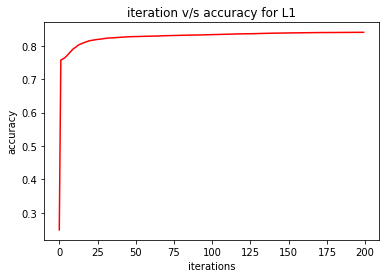

In [0]:
alpha = 0.3
l1_param = 0.01
epochs = 200
acc, cost, theta = log_reg_L1(X_train, y_train, alpha, l1_param, epochs)

plt.title("iteration v/s accuracy for L1")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.plot(range(epochs), acc, c='r')
plt.show()

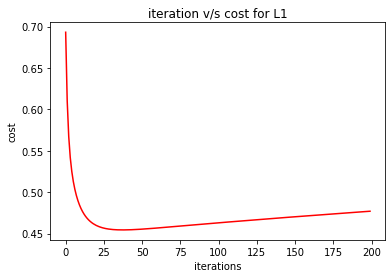

In [0]:
plt.title("iteration v/s cost for L1")
plt.xlabel("iterations")
plt.ylabel("cost")
plt.plot(range(epochs), cost, c='r')
plt.show()

In [0]:
print("accuracy :", acc[-1])

accuracy : 0.8401631191565546


**L2 or Ridge**

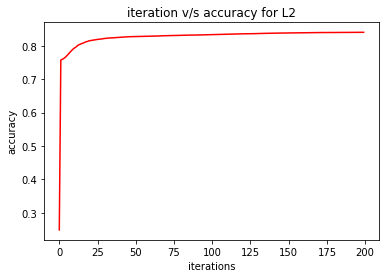

In [0]:
alpha = 0.3
l2_param = 0.01
epochs = 200
acc, cost, theta = log_reg_L2(X_train, y_train, alpha, l2_param, epochs)

plt.title("iteration v/s accuracy for L2")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.plot(range(epochs), acc, c='r')
plt.show()


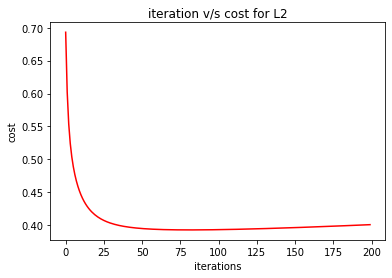

In [0]:
plt.title("iteration v/s cost for L2")
plt.xlabel("iterations")
plt.ylabel("cost")
plt.plot(range(epochs), cost, c='r')
plt.show()


In [0]:
print("accuracy :", acc[-1])

accuracy : 0.8401631191565546


#Question 2

In [0]:
from struct import unpack

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [0]:
# # from sklearn import metrics
# # import seaborn as sns
# # from struct import unpack
# # import gzip


# # !wget -O train-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# # !wget -O train-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# # !wget -O t10k-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# # !wget -O t10k-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

# # !pip install patool

# # import patoolib

# # patoolib.extract_archive('train-labels-idx1-ubyte.gz', outdir='unpack')
# # patoolib.extract_archive('train-images-idx3-ubyte.gz', outdir='unpack')
# # patoolib.extract_archive('t10k-images-idx3-ubyte.gz', outdir='unpack')
# # patoolib.extract_archive('t10k-labels-idx1-ubyte.gz', outdir='unpack')

# train_img, train_lbl = loadmnist('/unpack/train-images-idx3-ubyte.gz', '/unpack/train-labels-idx1-ubyte.gz')
# test_img, test_lbl = loadmnist('/content/unpack/t10k-images.idx3-ubyte', '/content/unpack/t10k-labels-idx1-ubyte')

In [0]:
from google.colab import drive
drive.mount("/content/drive")

train_img, train_lbl = loadmnist('/content/drive/My Drive/DataSets/MNIST/train-images-idx3-ubyte', '/content/drive/My Drive/DataSets/MNIST/train-labels-idx1-ubyte')
test_img, test_lbl = loadmnist('/content/drive/My Drive/DataSets/MNIST/t10k-images-idx3-ubyte', '/content/drive/My Drive/DataSets/MNIST/t10k-labels-idx1-ubyte')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(train_img.shape)

(60000, 784)


In [0]:
print(train_lbl.shape)

(60000,)


In [0]:
print(test_img.shape)

(10000, 784)


In [0]:
print(test_lbl.shape)

(10000,)


In [0]:
X_train_reshape = train_img.reshape(train_img.shape[0], 784)
X_test_reshape = test_img.reshape(test_img.shape[0], 784)

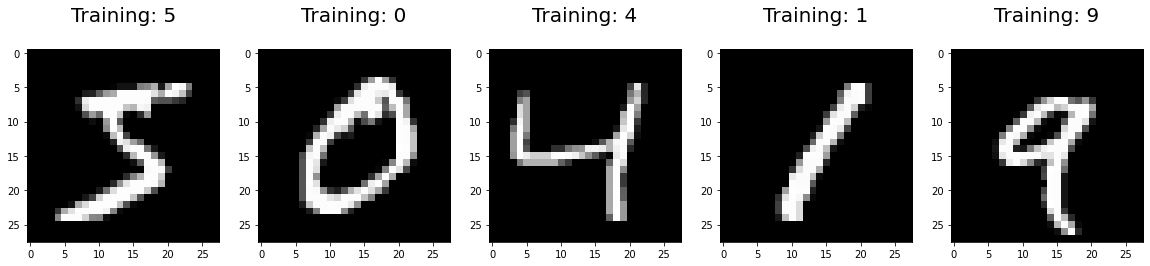

In [0]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

**L1 and L2 Regularization**

In [0]:
log_reg_L1 = LogisticRegression(penalty='l1', solver='liblinear',multi_class='ovr')
log_reg_L1.fit(train_img, train_lbl)
score_L1_test = log_reg_L1.score(test_img, test_lbl)
score_L1_train = log_reg_L1.score(train_img, train_lbl)

In [0]:
log_reg_L2 = LogisticRegression(penalty='l2', solver='lbfgs',multi_class='ovr')
log_reg_L2.fit(train_img, train_lbl)
score_L2_test = log_reg_L2.score(test_img, test_lbl)
score_L2_train = log_reg_L2.score(train_img, train_lbl)

In [0]:
score = [[score_L1_train*100, score_L1_test*100], [score_L2_train*100, score_L2_test*100]]
score_df = pd.DataFrame(score, index=["L1","L2"], columns=["Training Set","Testing Set"])
round(score_df,2)

,Training Set,Testing Set
L1,93.19,91.75
L2,92.61,91.78


good fit , as the model performs good on both training set as well as on testing set

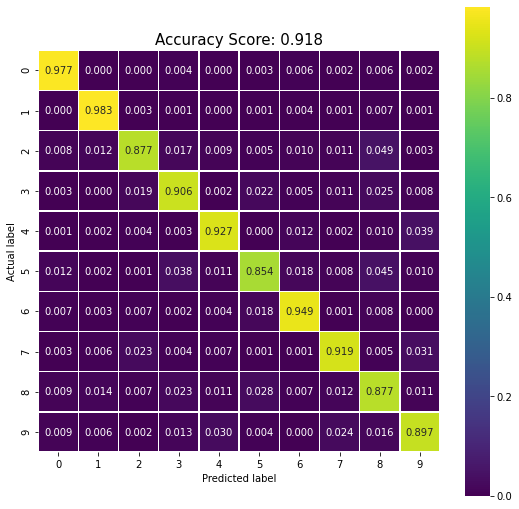

In [0]:
predictions = log_reg_L2.predict(test_img)
cm = metrics.confusion_matrix(test_lbl, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(score_L2_test) 
plt.title(all_sample_title, size = 15);

In [0]:
!pip install scikit-plot

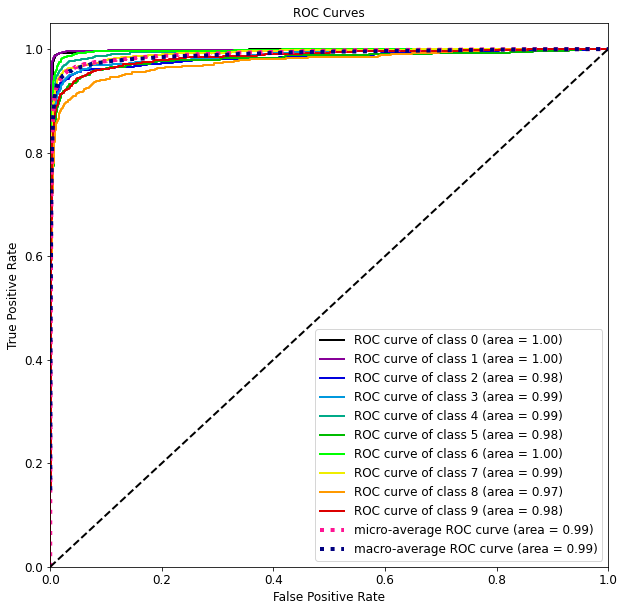

In [0]:

import scikitplot as skplt
import matplotlib.pyplot as plt


y_true = test_lbl
y_probas = log_reg_L2.predict_proba(test_img)
skplt.metrics.plot_roc_curve(y_true, y_probas,figsize=[10,10], text_fontsize='large', title_fontsize='large')
plt.show()